# Baseline PPO Controller
Train a PPO baseline policy.
### Environments:

#### InvertedPendulum-v2 environment:  
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant environment:
<img src="./notebookImages/ant.png" width="300">

<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *
import datetime

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(0)
torch.manual_seed(2)

%matplotlib inline

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [3]:
#From original PPO code, is used to setup multiprocessing environments
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

<h2>Constants and flags</h2>

In [4]:
VISUALIZE = False #Flag to save videos
logging_interval = 10 #Freqeuncy of video saving
COMPENSATION = False #Flag to implement compensation in test function
EARLY_STOPPING = True #Flag to stop when reward reaches threshold
num_envs = 4 #Number of environments to train across in multiprocessing

In [5]:
from gym import envs

#env_name = 'InvertedPendulumModified-multi-v10'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'
env_name = 'InvertedPendulum-v2'
env_key = "v10" #Unique identifier for custom envs (case sensitive)

""""
['InvertedPendulum-v2',
 'InvertedPendulumModified-base-v10',
 'InvertedPendulumModified-mass-v10',
 'InvertedPendulumModified-inertia-v10',
 'InvertedPendulumModified-friction-v10',
 'InvertedPendulumModified-tilt-v10',
 'InvertedPendulumModified-motor-v10',
 'InvertedPendulumModified-multi-v10']
 """

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = ['InvertedPendulum-v2'] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
training_env_index = test_env_names.index(env_name)

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
results_dir = os.path.join(script_dir, 'baseline_plots/' + env_name + time_stamp + '/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/' + env_name + time_stamp + '/')

if not os.path.isdir(results_dir):
    os.mkdir(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.mkdir(baseline_dir)
    
#Testing on original and new envs
tests = testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, training_env_index, logging_interval = 10)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

## Training baseline PPO controller

In [6]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

#PPO object
ppo_baseline = PPO(num_inputs, num_outputs)

In [7]:
max_frames = 30000
test_avg_rewards = []
test_stds = []
test_itrs = 20
save_interval = 5 #How often to save weights and figures

Saving figures


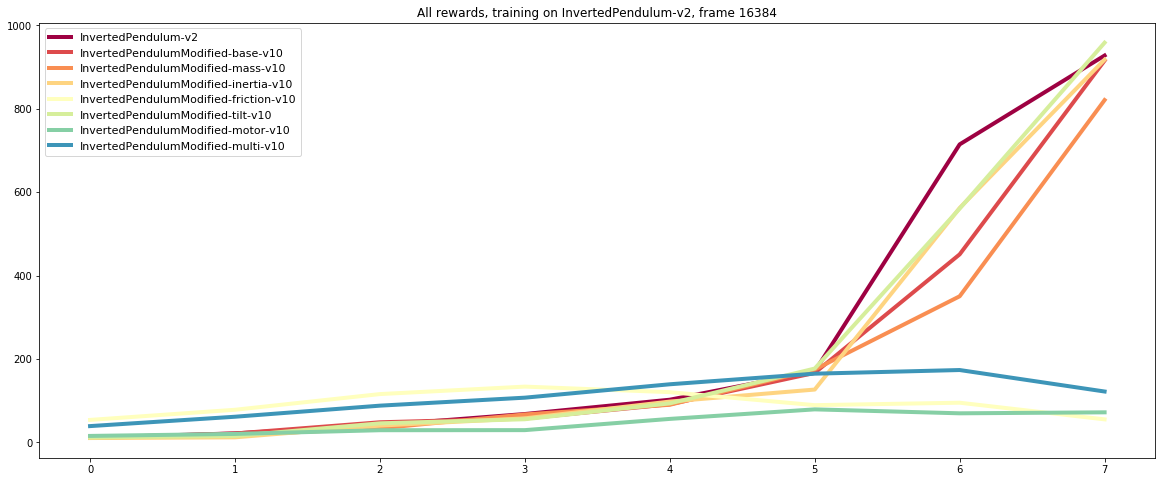

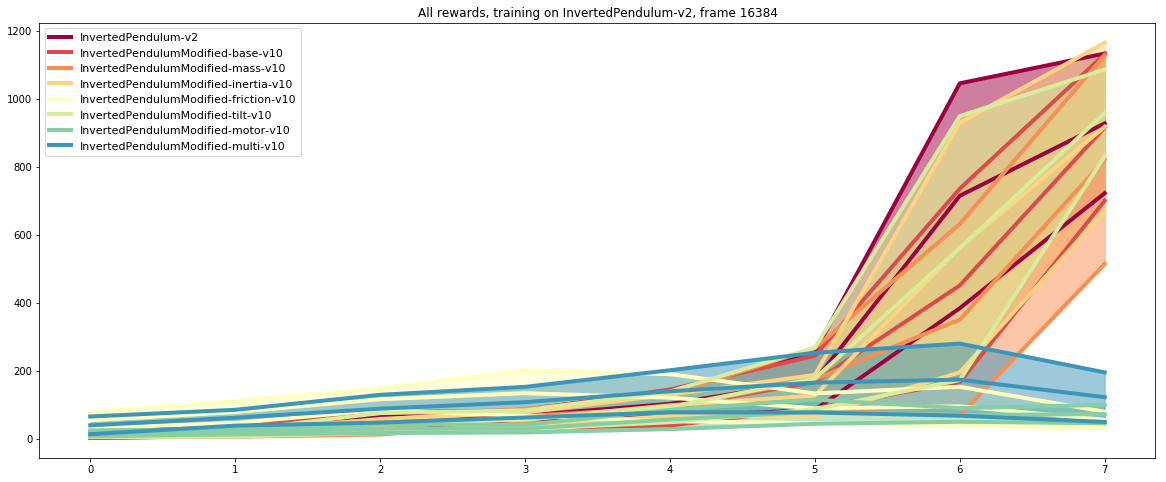

In [8]:
state = envs.reset()
early_stop = False #From original ppo code, flag used to end loop when stopping condition hit
ppo_updates = 0 #ppo update counter

#Which plotting figues to plot
indvplots=0; rewplots=1; stdplots=1
which_plts = [indvplots,rewplots,stdplots]

while ppo_baseline.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = ppo_baseline.collect_data(envs)
    
    #compute gae
    returns = ppo_baseline.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    ppo_baseline.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, ppo_baseline.model) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            ppo_baseline.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

ppo_baseline.save_weights(baseline_dir + env_name + '_endweights')